In [1]:
import scipy.stats
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px
from IPython.display import display, HTML

In [2]:
#Parametros de ejecucion del programa
nombreArchivoEstructuraDataset = "./Mapas de Transformación de Datos/Datos en Pasos Intermedios/Estructura del Dataset.txt"
nombreArchivoDatasetSinEtiquetar = "./Dataset sin Etiquetar.csv"
nombreArchivoDatasetEtiquetado = "./Dataset Etiquetado.csv"
nombreColumnaDuplicadaSalida = "Interested in buying a mobile home policy".replace(" ", "_")
nombreColumnaSalida = "Number of mobile home policies".replace(" ", "_")
nombreColumnaFase = "Phase"
etiquetaDatosEntrenamiento = "Training"
etiquetaDatosPrueba = "Test"
etiquetaVariablesCategoricas = "Categorical"
confidenceRatioForIndependeceHypothesisTest = 0.99

colorTextoVerde = (35, 155, 86)
colorTextoRojo = (176, 58, 46)

In [3]:
def printColouredText(text, foregroundColor = (0, 0, 0), backgroundColor = (255, 255, 255)):
    return "\033[48;2;{};{};{}m\033[38;2;{};{};{}m{}\033[38;2;0;0;0m\033[48;2;255;255;255m".format(backgroundColor[0], backgroundColor[1], backgroundColor[2], foregroundColor[0], foregroundColor[1], foregroundColor[2], text)

def highlightCountingPivotTableFor2DetailLevels(x):
    df = x.copy()
    k = list(df.columns.to_flat_index())
    df.loc[:, :] = "background-color: white!0"
    df[[k[-3:]]] = "font-weight: bold"
    df.iloc[-1, :] = "font-weight: bold"
    
    for a in cellsIndexesWithZeroValuesBySelectedColumns.keys():
        for ii in cellsIndexesWithZeroValuesBySelectedColumns[a]:
            df.loc[df.index[ii], a] = "background-color: rgb(245, 183, 177); font-weight: bold"
            
    for a in cellsIndexesWithMaximumValueBySelectedColumns.keys():
        for ii in cellsIndexesWithMaximumValueBySelectedColumns[a]:
            #df.loc[df.index[ii], a] = "background-color: rgb(250, 215, 160); font-weight: bold"
            df.loc[df.index[ii], a] = "background-color: rgb(171, 235, 198); font-weight: bold"
    
    for a in cellsIndexesWithMinimumValueBySelectedColumns.keys():
        for ii in cellsIndexesWithMinimumValueBySelectedColumns[a]:
            #df.loc[df.index[ii], a] = "background-color: rgb(250, 215, 160); font-weight: bold"
            df.loc[df.index[ii], a] = "background-color: rgb(249, 231, 159); font-weight: bold"
    
    return df

def buildCountingPivotTableFor2DetailLevels(dataframeSource, valuesColumn, indexColumn, mainColumnToGroup, secondaryColumnToGroup):
    pivotTableWith2DetailLevels = pd.pivot_table(dataframeSource, values = valuesColumn, index = indexColumn, columns = [secondaryColumnToGroup, mainColumnToGroup], aggfunc = 'count')
    pivotTableWith2DetailLevels.fillna(0.0, inplace = True)
    pivotTableWith1DetailLevel = pd.pivot_table(dataframeSource, values = valuesColumn, index = indexColumn, columns = mainColumnToGroup, aggfunc = 'count')
    pivotTableWith1DetailLevel.fillna(0.0, inplace = True)
    pivotTableWith1DetailLevel["General Total"] = pivotTableWith1DetailLevel[pivotTableWith1DetailLevel.columns].sum(axis = 1)
    mainColumnValuesList = list(pivotTableWith1DetailLevel.columns)
    pivotTableWith1DetailLevel.rename(columns = {tableColumn: ("", tableColumn) for tableColumn in pivotTableWith1DetailLevel.columns}, inplace = True)
    fullPivotTable = pd.concat([pivotTableWith2DetailLevels, pivotTableWith1DetailLevel], axis = 1)
    
    valuesSumTableByColumns = fullPivotTable.sum()
    valuesSumTableByColumns.name = "General Total"
    pivotTableSummarizedByRows = pd.DataFrame(valuesSumTableByColumns.transpose(), columns = fullPivotTable.columns, index = pd.Index([valuesSumTableByColumns.name], name = indexColumn))
    pivotTableSummarizedByRows.loc[valuesSumTableByColumns.name] = valuesSumTableByColumns.tolist()
    fullPivotTable = pd.concat([fullPivotTable, pivotTableSummarizedByRows])
    
    for column in fullPivotTable.columns:
        fullPivotTable[column] = [int(value) for value in fullPivotTable[column].tolist()]
    
    cellsIndexesWithZeroValuesBySelectedColumns = {}
    for column in mainColumnValuesList:
        cellsIndexesWithZeroValuesBySelectedColumns[("", column)] = []
        for rowIndex in range(len(fullPivotTable)):
            if fullPivotTable[("", column)].tolist()[rowIndex] == 0:
                cellsIndexesWithZeroValuesBySelectedColumns[("", column)].append(rowIndex)
    
    cellsIndexesWithMaximumValueBySelectedColumns = {}
    for column in mainColumnValuesList:
        cellsIndexesWithMaximumValueBySelectedColumns[("", column)] = []
        maximumValue = -1
        indexesListWithMaximumValue = []
        for rowIndex in range(len(fullPivotTable) - 1):
            if fullPivotTable[("", column)].tolist()[rowIndex] > maximumValue:
                maximumValue = fullPivotTable[("", column)].tolist()[rowIndex]
                indexesListWithMaximumValue = [rowIndex]
            elif fullPivotTable[("", column)].tolist()[rowIndex] == maximumValue:
                indexesListWithMaximumValue.append(rowIndex)
        cellsIndexesWithMaximumValueBySelectedColumns[("", column)] = indexesListWithMaximumValue
    
    cellsIndexesWithMinimumValueBySelectedColumns = {}
    for column in mainColumnValuesList:
        cellsIndexesWithMinimumValueBySelectedColumns[("", column)] = []
        minimumValue = float('inf')
        indexesListWithMinimumValue = []
        for rowIndex in range(len(fullPivotTable) - 1):
            if fullPivotTable[("", column)].tolist()[rowIndex] < minimumValue and fullPivotTable[("", column)].tolist()[rowIndex] != 0:
                minimumValue = fullPivotTable[("", column)].tolist()[rowIndex]
                indexesListWithMinimumValue = [rowIndex]
            elif fullPivotTable[("", column)].tolist()[rowIndex] == minimumValue:
                indexesListWithMinimumValue.append(rowIndex)
        cellsIndexesWithMinimumValueBySelectedColumns[("", column)] = indexesListWithMinimumValue
    
    frequencyTableWith2DetailLevels = fullPivotTable.copy()
    frequencyTableWith2DetailLevels = frequencyTableWith2DetailLevels[cellsIndexesWithZeroValuesBySelectedColumns.keys()]
    frequencyTableWith2DetailLevels = pd.DataFrame({column: frequencyTableWith2DetailLevels[column] for column in frequencyTableWith2DetailLevels.keys()}, index = pd.Index(frequencyTableWith2DetailLevels.index, name = indexColumn))
    return frequencyTableWith2DetailLevels, fullPivotTable, cellsIndexesWithZeroValuesBySelectedColumns, cellsIndexesWithMaximumValueBySelectedColumns, cellsIndexesWithMinimumValueBySelectedColumns

def applyHypothesisTestForVariablesIndependence(frequencyTableWith2DetailLevels, indexColumn, valuesColumn, confidenceRatio = 0.95):
    expectedFrequencyTableWith2DetailLevels = frequencyTableWith2DetailLevels.copy()
    numberValuesForFirstVariable = len(frequencyTableWith2DetailLevels) - 1
    numberValuesForSecondVariable = len(frequencyTableWith2DetailLevels.columns) - 1
    numberTotalObservations = frequencyTableWith2DetailLevels.iloc[numberValuesForFirstVariable, numberValuesForSecondVariable]
    print("Se va a realizar una prueba de hipótesis de independencia de variables, para las variables", printColouredText(indexColumn, colorTextoVerde), "y", printColouredText(valuesColumn, colorTextoVerde), "con un valor de confianza de", printColouredText(confidenceRatio, colorTextoVerde))
    print("Se tiene un total de", printColouredText(numberTotalObservations, colorTextoVerde), "observaciones, la variable", printColouredText(indexColumn, colorTextoRojo), "toma", printColouredText(numberValuesForFirstVariable, colorTextoRojo), "valores posibles, y la variable", printColouredText(valuesColumn, colorTextoRojo), "toma", printColouredText(numberValuesForSecondVariable, colorTextoRojo), "valores posibles")
    
    #Construccion de la tabla de frecuencias esperadas
    for rowIndex in range(numberValuesForFirstVariable):
        for columnIndex in range(numberValuesForSecondVariable):
            expectedFrequencyTableWith2DetailLevels.iloc[rowIndex, columnIndex] = frequencyTableWith2DetailLevels.iloc[numberValuesForFirstVariable, columnIndex] * frequencyTableWith2DetailLevels.iloc[rowIndex, numberValuesForSecondVariable] / numberTotalObservations
    
    #Calculo de valores chi cuadrado de prueba y chi cuadrado critico
    numberFreedomDegrees = (numberValuesForFirstVariable - 1) * (numberValuesForSecondVariable - 1)
    chiSquaredCriticalValue = scipy.stats.chi2.ppf(confidenceRatio, numberFreedomDegrees)
    chiSquaredTestValue = 0.0
    for rowIndex in range(numberValuesForFirstVariable):
        for columnIndex in range(numberValuesForSecondVariable):
            chiSquaredTestValue += np.power(frequencyTableWith2DetailLevels.iloc[rowIndex, columnIndex] - expectedFrequencyTableWith2DetailLevels.iloc[rowIndex, columnIndex], 2) / expectedFrequencyTableWith2DetailLevels.iloc[rowIndex, columnIndex]
    print("Se tiene(n)", printColouredText(numberFreedomDegrees, colorTextoVerde), "grado(s) de libertad, un valor estadístico crítico de", printColouredText(chiSquaredCriticalValue, colorTextoVerde), "y un valor estadístico de prueba de ", printColouredText(chiSquaredTestValue, colorTextoVerde))
    
    #Se toma la decision de aceptar o rechazar la hipotesis de independencia de las 2 variables
    decisionConfirmation = True
    if chiSquaredCriticalValue < chiSquaredTestValue:
        print("Como el valor de prueba supera el valor crítico, por lo tanto se", printColouredText("rechaza", colorTextoRojo), "la hipótesis nula de independencia de las variables, es decir, se tiene dependencia entre las variables", printColouredText(indexColumn, colorTextoRojo), "y", printColouredText(valuesColumn, colorTextoRojo))
        decisionConfirmation = False
    else:
        print("Como el valor de prueba no supera el valor crítico, por lo tanto se", printColouredText("acepta", colorTextoRojo), "la hipótesis nula de independencia de las variables, es decir, se tiene independencia entre las variables", printColouredText(indexColumn, colorTextoRojo), "y", printColouredText(valuesColumn, colorTextoRojo))
    return decisionConfirmation, expectedFrequencyTableWith2DetailLevels

def plotFrequencyTables(frequencyTableWith2DetailLevels, indexColumn, valuesColumn, barWidth = 1.0, barOffset = 0.0, barPlotOriginalOrientation = True):
    numberValuesForFirstVariable = len(frequencyTableWith2DetailLevels) - 1
    numberValuesForSecondVariable = len(frequencyTableWith2DetailLevels.columns) - 1
    valuesListForFirstVariable = list(frequencyTableWith2DetailLevels.index)[:numberValuesForFirstVariable]
    originalValuesListForSecondVariable = list(frequencyTableWith2DetailLevels.columns)[:numberValuesForSecondVariable]
    valuesListForSecondVariable = [pair[1] for pair in originalValuesListForSecondVariable]
    
    #Calculo de alturas de las barras respecto a la variable indicada
    barsHeightsListsGroupedByFirstVariable = {value: list(frequencyTableWith2DetailLevels.loc[value, frequencyTableWith2DetailLevels.columns[:numberValuesForSecondVariable]]) for value in valuesListForFirstVariable}
    barsHeightsListsGroupedBySecondVariable = {value: list(frequencyTableWith2DetailLevels.loc[frequencyTableWith2DetailLevels.index[:numberValuesForFirstVariable], ("", value)]) for value in valuesListForSecondVariable}
    
    #Calculo de posiciones de las barras respecto a la variable indicada
    barsPositionsListsGroupedByFirstVariable = {value: [(index * (len(valuesListForFirstVariable) + 1) + valuesListForFirstVariable.index(value)) * barWidth + index * barOffset for index in list(np.arange(numberValuesForSecondVariable))] for value in valuesListForFirstVariable}
    barsPositionsListsGroupedBySecondVariable = {value: [(index * (len(valuesListForSecondVariable) + 1) + valuesListForSecondVariable.index(value)) * barWidth + index * barOffset for index in list(np.arange(numberValuesForFirstVariable))] for value in valuesListForSecondVariable}
    
    #Calculo de posiciones de las etiquetas de valores de la variable indicada
    firstAndLastBarsPositionsListGroupedBySecondVariable = {value: [(valuesListForSecondVariable.index(value) * (len(valuesListForFirstVariable) + 1)) * barWidth + valuesListForSecondVariable.index(value) * barOffset, ((valuesListForSecondVariable.index(value) + 1) * (len(valuesListForFirstVariable) + 1) - 1) * barWidth + valuesListForSecondVariable.index(value) * barOffset] for value in valuesListForSecondVariable}
    firstAndLastBarsPositionsListGroupedByFirstVariable = {value: [(valuesListForFirstVariable.index(value) * (len(valuesListForSecondVariable) + 1)) * barWidth + valuesListForFirstVariable.index(value) * barOffset, ((valuesListForFirstVariable.index(value) + 1) * (len(valuesListForSecondVariable) + 1) - 1) * barWidth + valuesListForFirstVariable.index(value) * barOffset] for value in valuesListForFirstVariable}
    barsLabelsListGroupedBySecondVariable = [np.mean(firstAndLastBarsPositionsListGroupedBySecondVariable[value]) for value in valuesListForSecondVariable]
    barsLabelsListGroupedByFirstVariable = [np.mean(firstAndLastBarsPositionsListGroupedByFirstVariable[value]) for value in valuesListForFirstVariable]
    
    #Obtencion de parametros para la grafica del diagrama de barras agrupadas
    barsColorsListInHexadecimal = None
    barsHeightsListsGroupedByIndicatedVariable = None
    barsPositionsListsGroupedByIndicatedVariable = None
    legendLabelsValuesList = None
    plotXLabelsPositionsList = None
    plotXLabelsValuesList = None
    plotTitle = None
    plotXLabel = None
    legendTitle = None
    if barPlotOriginalOrientation == True:
        #Obtencion de la gama de colores para las barras
        if numberValuesForSecondVariable <= 10:
            barsColorsListInHexadecimal = px.colors.qualitative.Plotly
        else:
            colorsMap = mpl.cm.get_cmap('jet')
            barsColorsListInRGB = [colorsMap(number) for number in list(np.linspace(0.0, 1.0, num = numberValuesForSecondVariable))]
            barsColorsListInHexadecimal = ["#{:02x}{:02x}{:02x}".format(int(255 * component[0]), int(255 * component[1]), int(255 * component[2])) for component in barsColorsListInRGB]
        
        barsHeightsListsGroupedByIndicatedVariable = barsHeightsListsGroupedBySecondVariable
        barsPositionsListsGroupedByIndicatedVariable = barsPositionsListsGroupedBySecondVariable
        legendLabelsValuesList = valuesListForSecondVariable
        plotXLabelsPositionsList = barsLabelsListGroupedByFirstVariable
        plotXLabelsValuesList = valuesListForFirstVariable
        plotTitle = "Distribución de Frecuencias de " + valuesColumn + "\ncon respecto a " + indexColumn
        plotXLabel = valuesColumn
        legendTitle = indexColumn
    else:
        #Obtencion de la gama de colores para las barras
        if numberValuesForFirstVariable <= 10:
            barsColorsListInHexadecimal = px.colors.qualitative.Plotly
        else:
            colorsMap = mpl.cm.get_cmap('jet')
            barsColorsListInRGB = [colorsMap(number) for number in list(np.linspace(0.0, 1.0, num = numberValuesForFirstVariable))]
            barsColorsListInHexadecimal = ["#{:02x}{:02x}{:02x}".format(int(255 * component[0]), int(255 * component[1]), int(255 * component[2])) for component in barsColorsListInRGB]
        
        barsHeightsListsGroupedByIndicatedVariable = barsHeightsListsGroupedByFirstVariable
        barsPositionsListsGroupedByIndicatedVariable = barsPositionsListsGroupedByFirstVariable
        legendLabelsValuesList = valuesListForFirstVariable
        plotXLabelsPositionsList = barsLabelsListGroupedBySecondVariable
        plotXLabelsValuesList = valuesListForSecondVariable
        plotTitle = "Distribución de Frecuencias de " + indexColumn + "\ncon respecto a " + valuesColumn
        plotXLabel = indexColumn
        legendTitle = valuesColumn
    
    plt.grid(True, zorder = 0)
    for value in legendLabelsValuesList:
        plt.bar(barsPositionsListsGroupedByIndicatedVariable[value], barsHeightsListsGroupedByIndicatedVariable[value], color = barsColorsListInHexadecimal[legendLabelsValuesList.index(value)], edgecolor = "black", width = barWidth, label = value, zorder = 3)
    plt.title(plotTitle)
    plt.xlabel(plotXLabel)
    plt.ylabel("Frecuencia")
    plt.xticks(plotXLabelsPositionsList, plotXLabelsValuesList)
    plt.legend(title = legendTitle, bbox_to_anchor = (1.0, 0.5), loc = 'center left', borderaxespad = 1.0)
    plt.tight_layout()

In [4]:
structureDatasetFile = pd.read_csv(nombreArchivoEstructuraDataset, sep = ";", decimal = ".")
fieldNamesList = structureDatasetFile["Field Name"].tolist()
respectiveVariableKindsList = structureDatasetFile["Variable Kind"].tolist()

In [5]:
notLabeledDatasetFile = pd.read_csv(nombreArchivoDatasetSinEtiquetar, sep = ";", decimal = ".")

print("Se ha extraído la información del archivo", printColouredText(nombreArchivoDatasetSinEtiquetar, colorTextoRojo))
print("Se tiene(n)", printColouredText(str(len(notLabeledDatasetFile.index)) + " dato(s)", colorTextoVerde))

Se ha extraído la información del archivo ./Dataset sin Etiquetar.csv
Se tiene(n) 9822 dato(s)


In [6]:
notLabeledDatasetFile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9822 entries, 0 to 9821
Data columns (total 87 columns):
 #   Column                                            Non-Null Count  Dtype 
---  ------                                            --------------  ----- 
 0   Customer Subtype                                  9822 non-null   int64 
 1   Number of houses                                  9822 non-null   int64 
 2   Avg size househol                                 9822 non-null   int64 
 3   Avg age                                           9822 non-null   int64 
 4   Customer main type                                9822 non-null   int64 
 5   Roman catholic                                    9822 non-null   int64 
 6   Protestant                                        9822 non-null   int64 
 7   Other religion                                    9822 non-null   int64 
 8   No religion                                       9822 non-null   int64 
 9   Married                       

In [7]:
labeledDatasetFile = pd.read_csv(nombreArchivoDatasetEtiquetado, sep = ";", decimal = ".")
labeledDatasetFile[nombreColumnaDuplicadaSalida] = labeledDatasetFile[nombreColumnaSalida].tolist()
labeledDatasetFile.replace({nombreColumnaDuplicadaSalida: {0: "No", 1: "Yes"}}, inplace = True)

#Filtrado de informacion para separar el dataset de entrenamiento y el dataset de prueba del dataset completo
trainingDatasetFile = labeledDatasetFile[labeledDatasetFile[nombreColumnaFase].str.contains(etiquetaDatosEntrenamiento)]
testDatasetFile = labeledDatasetFile[labeledDatasetFile[nombreColumnaFase].str.contains(etiquetaDatosPrueba)]

print("Se ha extraído la información del archivo", printColouredText(nombreArchivoDatasetEtiquetado, colorTextoRojo))
print("Se tiene(n)", printColouredText(str(len(labeledDatasetFile.index)) + " dato(s)", colorTextoVerde))
print("Se tiene(n) de", printColouredText(str(len(trainingDatasetFile.index)) + " dato(s) de entrenamiento", colorTextoVerde))
print("Se tiene(n) de", printColouredText(str(len(testDatasetFile.index)) + " dato(s) de prueba", colorTextoVerde))

Se ha extraído la información del archivo ./Dataset Etiquetado.csv
Se tiene(n) 9822 dato(s)
Se tiene(n) de 5822 dato(s) de entrenamiento
Se tiene(n) de 4000 dato(s) de prueba


In [8]:
pivotTablesList = {}

prefix = "Label_"
variableIndex = 1
for nombreColumna in notLabeledDatasetFile.columns:
    if nombreColumna != nombreColumnaSalida.replace("_", " ").replace("-", " ") and nombreColumna != nombreColumnaDuplicadaSalida.replace("_", " ").replace("-", " ") and nombreColumna != nombreColumnaFase:
        indexCol = fieldNamesList.index(nombreColumna)
        variableKind = respectiveVariableKindsList[indexCol]
        
        if variableKind == etiquetaVariablesCategoricas:
            print("frequencyTableWithBothDetailLevels, pivotTablesList[\"" + nombreColumna + "\"], cellsIndexesWithZeroValuesBySelectedColumns, cellsIndexesWithMaximumValueBySelectedColumns, cellsIndexesWithMinimumValueBySelectedColumns = buildCountingPivotTableFor2DetailLevels(labeledDatasetFile, nombreColumnaSalida, \"" + prefix + nombreColumna.replace(" ", "_").replace("-", "_") + "\", nombreColumnaDuplicadaSalida, nombreColumnaFase)")
        else:
            print("frequencyTableWithBothDetailLevels, pivotTablesList[\"" + nombreColumna + "\"], cellsIndexesWithZeroValuesBySelectedColumns, cellsIndexesWithMaximumValueBySelectedColumns, cellsIndexesWithMinimumValueBySelectedColumns = buildCountingPivotTableFor2DetailLevels(labeledDatasetFile, nombreColumnaSalida, \"" + nombreColumna.replace(" ", "_").replace("-", "_") + "\", nombreColumnaDuplicadaSalida, nombreColumnaFase)")
        print("display(pivotTablesList[\"" + nombreColumna + "\"].style.apply(highlightCountingPivotTableFor2DetailLevels, axis = None))\n")
        print("variablesIndependenceDecisionConfirmation, expectedFrequencyTableWithBothDetailLevels = applyHypothesisTestForVariablesIndependence(frequencyTableWithBothDetailLevels, \"" + nombreColumna + "\", nombreColumnaDuplicadaSalida, confidenceRatio = confidenceRatioForIndependeceHypothesisTest)")
        print("if variablesIndependenceDecisionConfirmation == True:")
        print("\toutputIndependentVariableslist.append(\"" + nombreColumna + "\")")
        print("else:")
        print("\toutputDependentVariableslist.append(\"" + nombreColumna + "\")\n")
        print("plt.figure(num = " + str(variableIndex) + ", figsize = (9.5, 10))")
        print("plotFrequencyTables(frequencyTableWithBothDetailLevels, nombreColumnaDuplicadaSalida, \"" + nombreColumna + "\", barWidth = 1.0, barOffset = 3.5, barPlotOriginalOrientation = False)")
        print("plt.show()")
        print("\n" + printColouredText("-" * 100, colorTextoRojo) + "\n")
        variableIndex += 1

outputIndependentVariableslist = []
outputDependentVariableslist = []

%matplotlib notebook

frequencyTableWithBothDetailLevels, pivotTablesList["Customer Subtype"], cellsIndexesWithZeroValuesBySelectedColumns, cellsIndexesWithMaximumValueBySelectedColumns, cellsIndexesWithMinimumValueBySelectedColumns = buildCountingPivotTableFor2DetailLevels(labeledDatasetFile, nombreColumnaSalida, "Label_Customer_Subtype", nombreColumnaDuplicadaSalida, nombreColumnaFase)
display(pivotTablesList["Customer Subtype"].style.apply(highlightCountingPivotTableFor2DetailLevels, axis = None))

variablesIndependenceDecisionConfirmation, expectedFrequencyTableWithBothDetailLevels = applyHypothesisTestForVariablesIndependence(frequencyTableWithBothDetailLevels, "Customer Subtype", nombreColumnaDuplicadaSalida, confidenceRatio = confidenceRatioForIndependeceHypothesisTest)
if variablesIndependenceDecisionConfirmation == True:
	outputIndependentVariableslist.append("Customer Subtype")
else:
	outputDependentVariableslist.append("Customer Subtype")

plt.figure(num = 1, figsize = (9.5, 10))
plotFrequencyTab

Se va a realizar una prueba de hipótesis de independencia de variables, para las variables Customer Subtype y Interested_in_buying_a_mobile_home_policy con un valor de confianza de 0.99
Se tiene un total de 9822 observaciones, la variable Customer Subtype toma 39 valores posibles, y la variable Interested_in_buying_a_mobile_home_policy toma 2 valores posibles
Se tiene(n) 38 grado(s) de libertad, un valor estadístico crítico de 61.1620867636897 y un valor estadístico de prueba de  194.89710637018567
Como el valor de prueba supera el valor crítico, por lo tanto se rechaza la hipótesis nula de independencia de las variables, es decir, se tiene dependencia entre las variables Customer Subtype y Interested_in_buying_a_mobile_home_policy


<IPython.core.display.Javascript object>


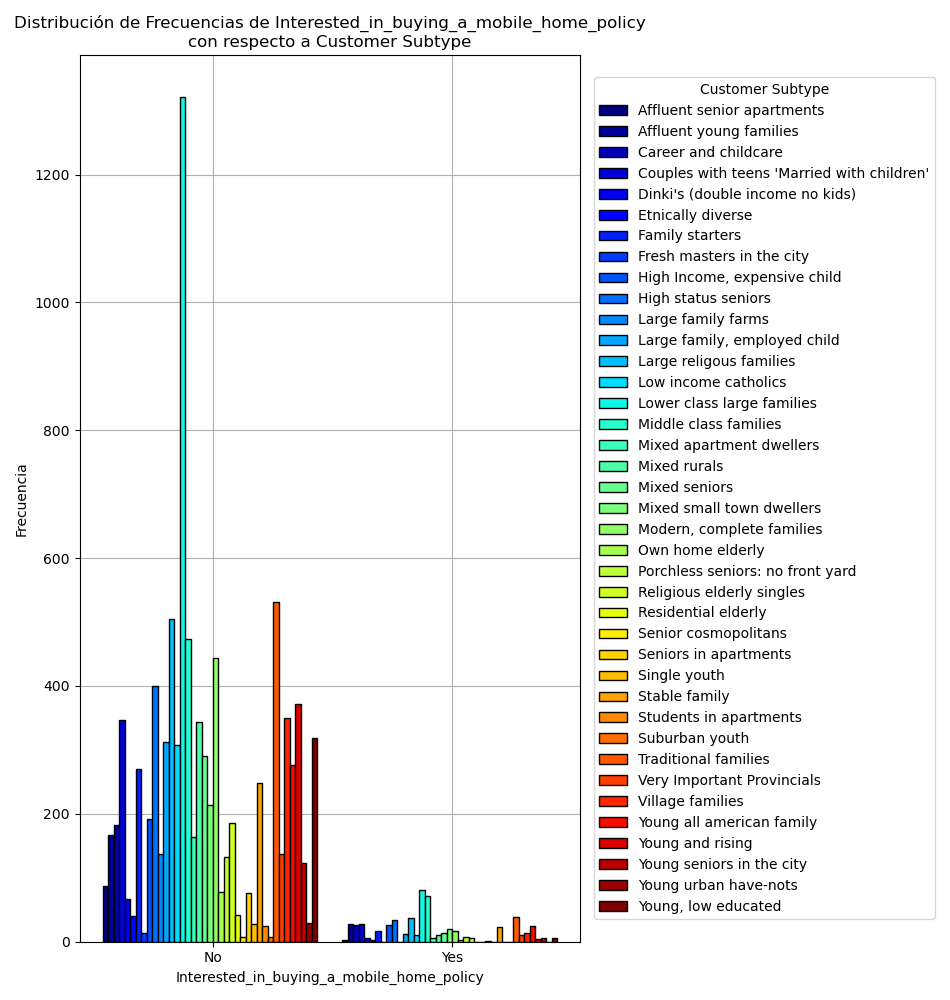

In [9]:
frequencyTableWithBothDetailLevels, pivotTablesList["Customer Subtype"], cellsIndexesWithZeroValuesBySelectedColumns, cellsIndexesWithMaximumValueBySelectedColumns, cellsIndexesWithMinimumValueBySelectedColumns = buildCountingPivotTableFor2DetailLevels(labeledDatasetFile, nombreColumnaSalida, "Label_Customer_Subtype", nombreColumnaDuplicadaSalida, nombreColumnaFase)
display(pivotTablesList["Customer Subtype"].style.apply(highlightCountingPivotTableFor2DetailLevels, axis = None))

variablesIndependenceDecisionConfirmation, expectedFrequencyTableWithBothDetailLevels = applyHypothesisTestForVariablesIndependence(frequencyTableWithBothDetailLevels, "Customer Subtype", nombreColumnaDuplicadaSalida, confidenceRatio = confidenceRatioForIndependeceHypothesisTest)
if variablesIndependenceDecisionConfirmation == True:
    outputIndependentVariableslist.append("Customer Subtype")
else:
    outputDependentVariableslist.append("Customer Subtype")

plt.figure(num = 1, figsize = (9.5, 10))
plotFrequencyTables(frequencyTableWithBothDetailLevels, nombreColumnaDuplicadaSalida, "Customer Subtype", barWidth = 1.0, barOffset = 3.5, barPlotOriginalOrientation = False)
plt.show()

Se va a realizar una prueba de hipótesis de independencia de variables, para las variables Number of houses y Interested_in_buying_a_mobile_home_policy con un valor de confianza de 0.99
Se tiene un total de 9822 observaciones, la variable Number of houses toma 9 valores posibles, y la variable Interested_in_buying_a_mobile_home_policy toma 2 valores posibles
Se tiene(n) 8 grado(s) de libertad, un valor estadístico crítico de 20.090235029663233 y un valor estadístico de prueba de  5.8560579742457435
Como el valor de prueba no supera el valor crítico, por lo tanto se acepta la hipótesis nula de independencia de las variables, es decir, se tiene independencia entre las variables Number of houses y Interested_in_buying_a_mobile_home_policy


<IPython.core.display.Javascript object>


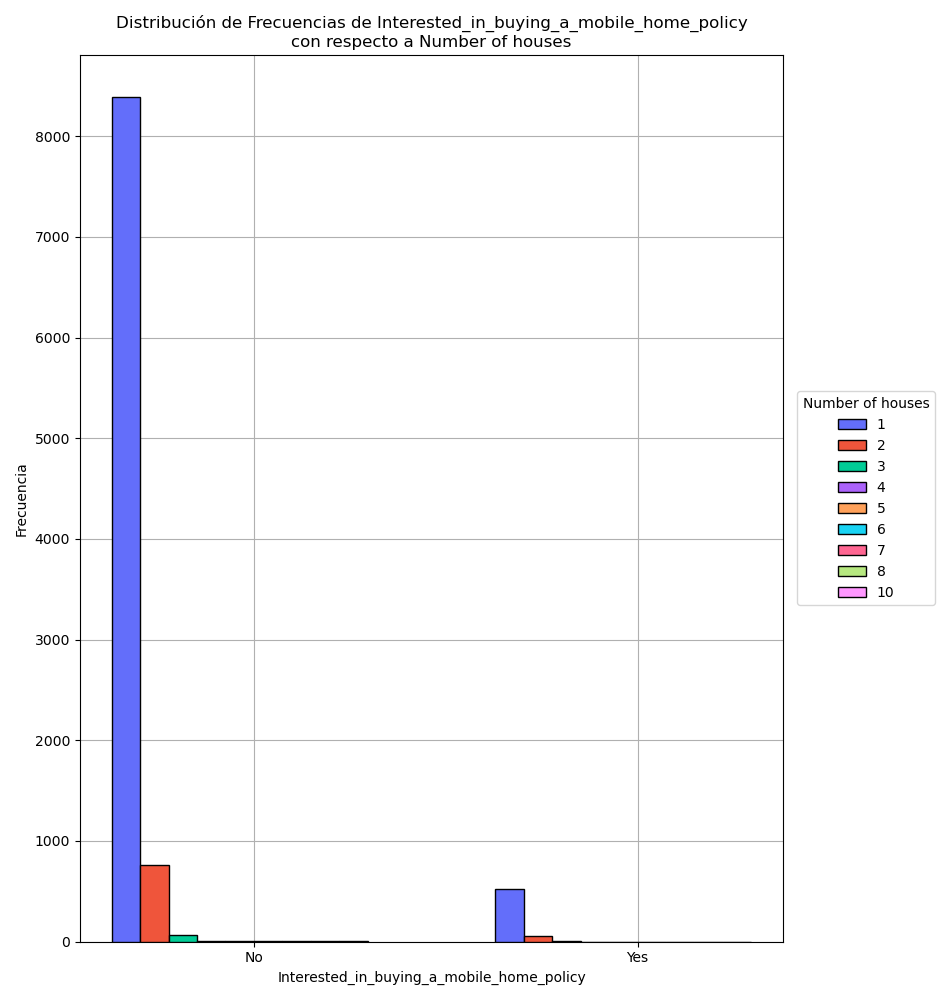

In [10]:
frequencyTableWithBothDetailLevels, pivotTablesList["Number of houses"], cellsIndexesWithZeroValuesBySelectedColumns, cellsIndexesWithMaximumValueBySelectedColumns, cellsIndexesWithMinimumValueBySelectedColumns = buildCountingPivotTableFor2DetailLevels(labeledDatasetFile, nombreColumnaSalida, "Number_of_houses", nombreColumnaDuplicadaSalida, nombreColumnaFase)
display(pivotTablesList["Number of houses"].style.apply(highlightCountingPivotTableFor2DetailLevels, axis = None))

variablesIndependenceDecisionConfirmation, expectedFrequencyTableWithBothDetailLevels = applyHypothesisTestForVariablesIndependence(frequencyTableWithBothDetailLevels, "Number of houses", nombreColumnaDuplicadaSalida, confidenceRatio = confidenceRatioForIndependeceHypothesisTest)
if variablesIndependenceDecisionConfirmation == True:
    outputIndependentVariableslist.append("Number of houses")
else:
    outputDependentVariableslist.append("Number of houses")

plt.figure(num = 2, figsize = (9.5, 10))
plotFrequencyTables(frequencyTableWithBothDetailLevels, nombreColumnaDuplicadaSalida, "Number of houses", barWidth = 1.0, barOffset = 3.5, barPlotOriginalOrientation = False)
plt.show()

Se va a realizar una prueba de hipótesis de independencia de variables, para las variables Avg size househol y Interested_in_buying_a_mobile_home_policy con un valor de confianza de 0.99
Se tiene un total de 9822 observaciones, la variable Avg size househol toma 6 valores posibles, y la variable Interested_in_buying_a_mobile_home_policy toma 2 valores posibles
Se tiene(n) 5 grado(s) de libertad, un valor estadístico crítico de 15.08627246938899 y un valor estadístico de prueba de  27.183301308797034
Como el valor de prueba supera el valor crítico, por lo tanto se rechaza la hipótesis nula de independencia de las variables, es decir, se tiene dependencia entre las variables Avg size househol y Interested_in_buying_a_mobile_home_policy


<IPython.core.display.Javascript object>


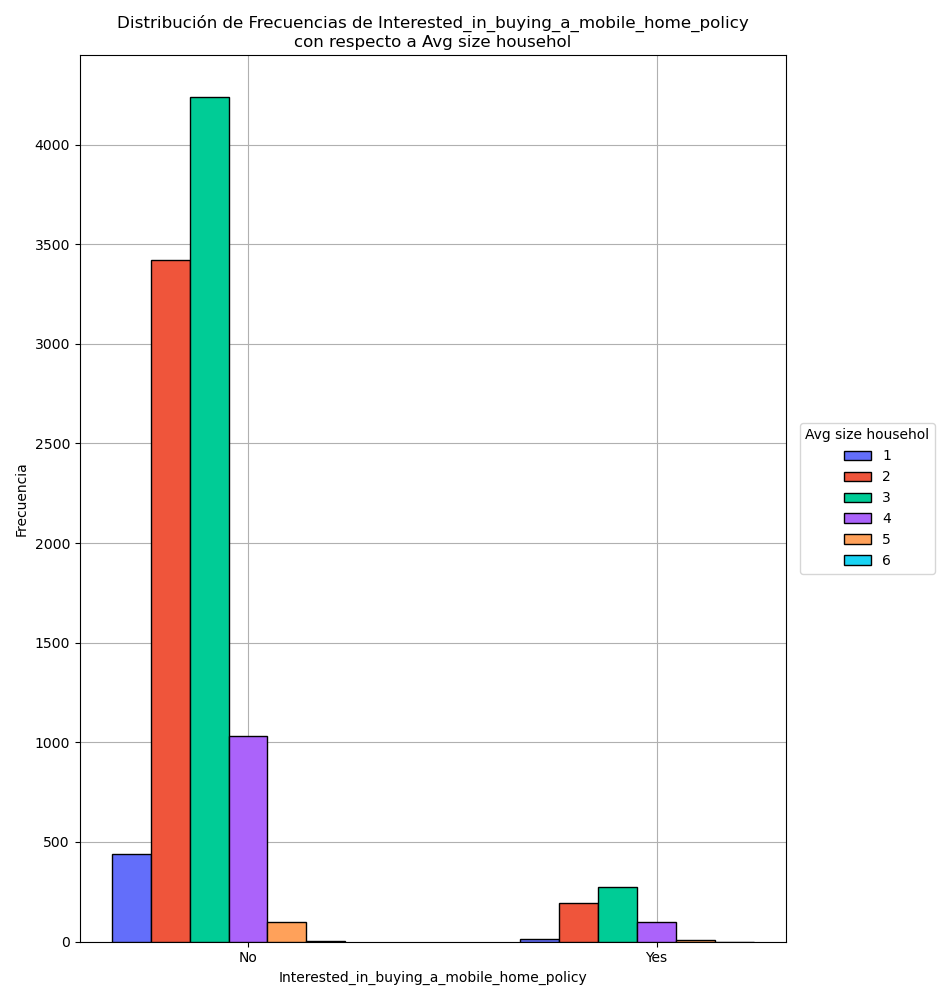

In [11]:
frequencyTableWithBothDetailLevels, pivotTablesList["Avg size househol"], cellsIndexesWithZeroValuesBySelectedColumns, cellsIndexesWithMaximumValueBySelectedColumns, cellsIndexesWithMinimumValueBySelectedColumns = buildCountingPivotTableFor2DetailLevels(labeledDatasetFile, nombreColumnaSalida, "Avg_size_househol", nombreColumnaDuplicadaSalida, nombreColumnaFase)
display(pivotTablesList["Avg size househol"].style.apply(highlightCountingPivotTableFor2DetailLevels, axis = None))

variablesIndependenceDecisionConfirmation, expectedFrequencyTableWithBothDetailLevels = applyHypothesisTestForVariablesIndependence(frequencyTableWithBothDetailLevels, "Avg size househol", nombreColumnaDuplicadaSalida, confidenceRatio = confidenceRatioForIndependeceHypothesisTest)
if variablesIndependenceDecisionConfirmation == True:
    outputIndependentVariableslist.append("Avg size househol")
else:
    outputDependentVariableslist.append("Avg size househol")

plt.figure(num = 3, figsize = (9.5, 10))
plotFrequencyTables(frequencyTableWithBothDetailLevels, nombreColumnaDuplicadaSalida, "Avg size househol", barWidth = 1.0, barOffset = 3.5, barPlotOriginalOrientation = False)
plt.show()

Se va a realizar una prueba de hipótesis de independencia de variables, para las variables Avg age y Interested_in_buying_a_mobile_home_policy con un valor de confianza de 0.99
Se tiene un total de 9822 observaciones, la variable Avg age toma 6 valores posibles, y la variable Interested_in_buying_a_mobile_home_policy toma 2 valores posibles
Se tiene(n) 5 grado(s) de libertad, un valor estadístico crítico de 15.08627246938899 y un valor estadístico de prueba de  7.191409701193992
Como el valor de prueba no supera el valor crítico, por lo tanto se acepta la hipótesis nula de independencia de las variables, es decir, se tiene independencia entre las variables Avg age y Interested_in_buying_a_mobile_home_policy


<IPython.core.display.Javascript object>


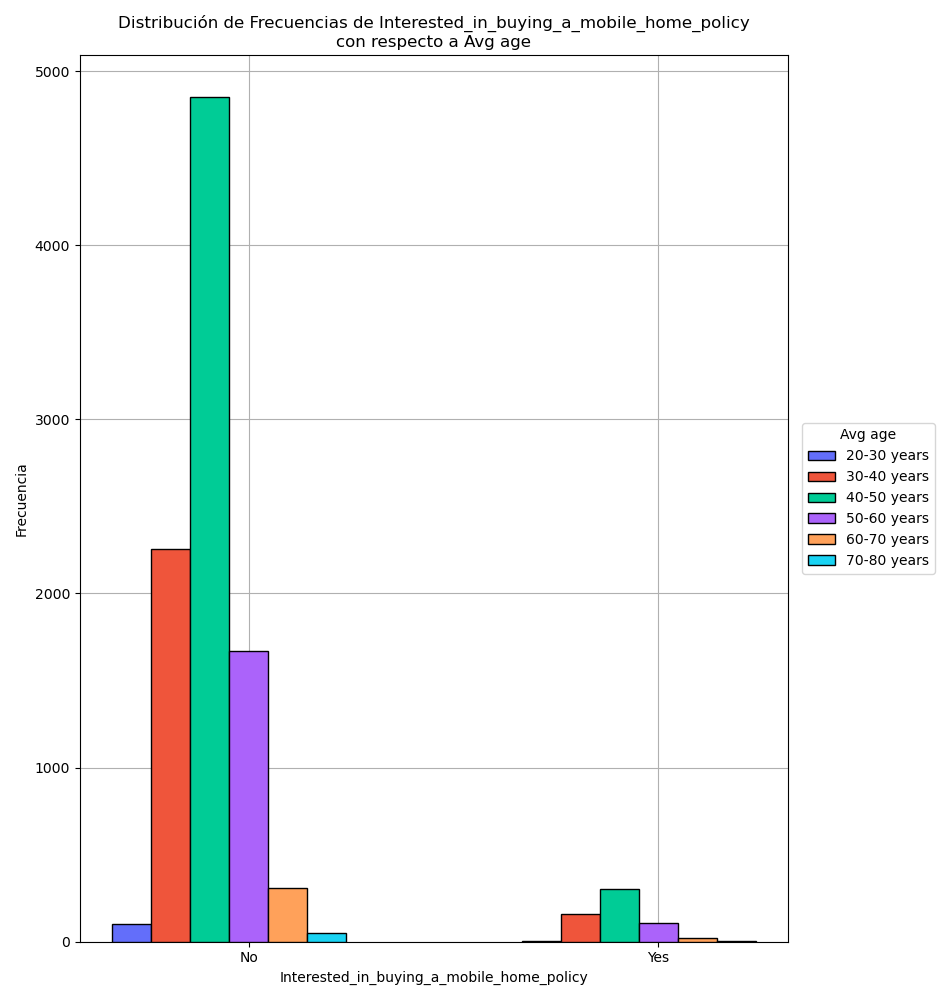

In [12]:
frequencyTableWithBothDetailLevels, pivotTablesList["Avg age"], cellsIndexesWithZeroValuesBySelectedColumns, cellsIndexesWithMaximumValueBySelectedColumns, cellsIndexesWithMinimumValueBySelectedColumns = buildCountingPivotTableFor2DetailLevels(labeledDatasetFile, nombreColumnaSalida, "Label_Avg_age", nombreColumnaDuplicadaSalida, nombreColumnaFase)
display(pivotTablesList["Avg age"].style.apply(highlightCountingPivotTableFor2DetailLevels, axis = None))

variablesIndependenceDecisionConfirmation, expectedFrequencyTableWithBothDetailLevels = applyHypothesisTestForVariablesIndependence(frequencyTableWithBothDetailLevels, "Avg age", nombreColumnaDuplicadaSalida, confidenceRatio = confidenceRatioForIndependeceHypothesisTest)
if variablesIndependenceDecisionConfirmation == True:
    outputIndependentVariableslist.append("Avg age")
else:
    outputDependentVariableslist.append("Avg age")

plt.figure(num = 4, figsize = (9.5, 10))
plotFrequencyTables(frequencyTableWithBothDetailLevels, nombreColumnaDuplicadaSalida, "Avg age", barWidth = 1.0, barOffset = 3.5, barPlotOriginalOrientation = False)
plt.show()

Se va a realizar una prueba de hipótesis de independencia de variables, para las variables Customer main type y Interested_in_buying_a_mobile_home_policy con un valor de confianza de 0.99
Se tiene un total de 9822 observaciones, la variable Customer main type toma 10 valores posibles, y la variable Interested_in_buying_a_mobile_home_policy toma 2 valores posibles
Se tiene(n) 9 grado(s) de libertad, un valor estadístico crítico de 21.665994333461924 y un valor estadístico de prueba de  130.8436174908156
Como el valor de prueba supera el valor crítico, por lo tanto se rechaza la hipótesis nula de independencia de las variables, es decir, se tiene dependencia entre las variables Customer main type y Interested_in_buying_a_mobile_home_policy


<IPython.core.display.Javascript object>


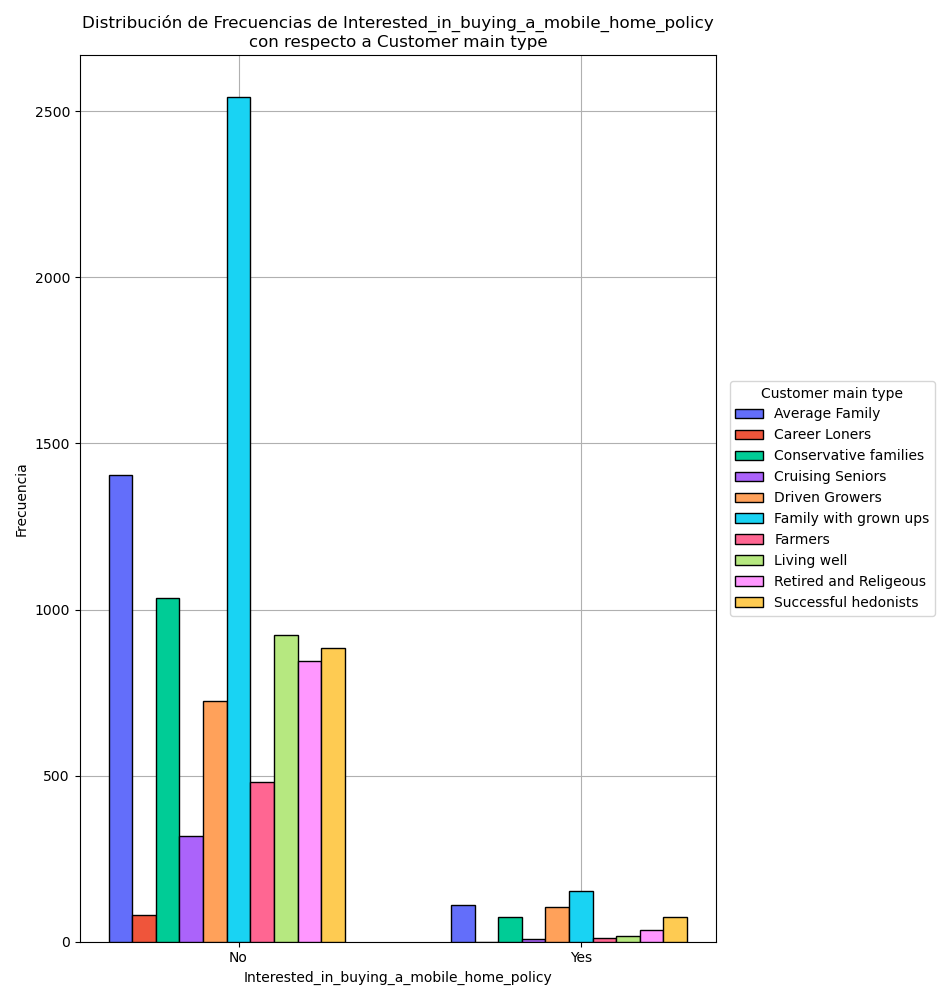

In [13]:
frequencyTableWithBothDetailLevels, pivotTablesList["Customer main type"], cellsIndexesWithZeroValuesBySelectedColumns, cellsIndexesWithMaximumValueBySelectedColumns, cellsIndexesWithMinimumValueBySelectedColumns = buildCountingPivotTableFor2DetailLevels(labeledDatasetFile, nombreColumnaSalida, "Label_Customer_main_type", nombreColumnaDuplicadaSalida, nombreColumnaFase)
display(pivotTablesList["Customer main type"].style.apply(highlightCountingPivotTableFor2DetailLevels, axis = None))

variablesIndependenceDecisionConfirmation, expectedFrequencyTableWithBothDetailLevels = applyHypothesisTestForVariablesIndependence(frequencyTableWithBothDetailLevels, "Customer main type", nombreColumnaDuplicadaSalida, confidenceRatio = confidenceRatioForIndependeceHypothesisTest)
if variablesIndependenceDecisionConfirmation == True:
    outputIndependentVariableslist.append("Customer main type")
else:
    outputDependentVariableslist.append("Customer main type")

plt.figure(num = 5, figsize = (9.5, 10))
plotFrequencyTables(frequencyTableWithBothDetailLevels, nombreColumnaDuplicadaSalida, "Customer main type", barWidth = 1.0, barOffset = 3.5, barPlotOriginalOrientation = False)
plt.show()

Se va a realizar una prueba de hipótesis de independencia de variables, para las variables Roman catholic y Interested_in_buying_a_mobile_home_policy con un valor de confianza de 0.99
Se tiene un total de 9822 observaciones, la variable Roman catholic toma 10 valores posibles, y la variable Interested_in_buying_a_mobile_home_policy toma 2 valores posibles
Se tiene(n) 9 grado(s) de libertad, un valor estadístico crítico de 21.665994333461924 y un valor estadístico de prueba de  13.579201291261585
Como el valor de prueba no supera el valor crítico, por lo tanto se acepta la hipótesis nula de independencia de las variables, es decir, se tiene independencia entre las variables Roman catholic y Interested_in_buying_a_mobile_home_policy


<IPython.core.display.Javascript object>


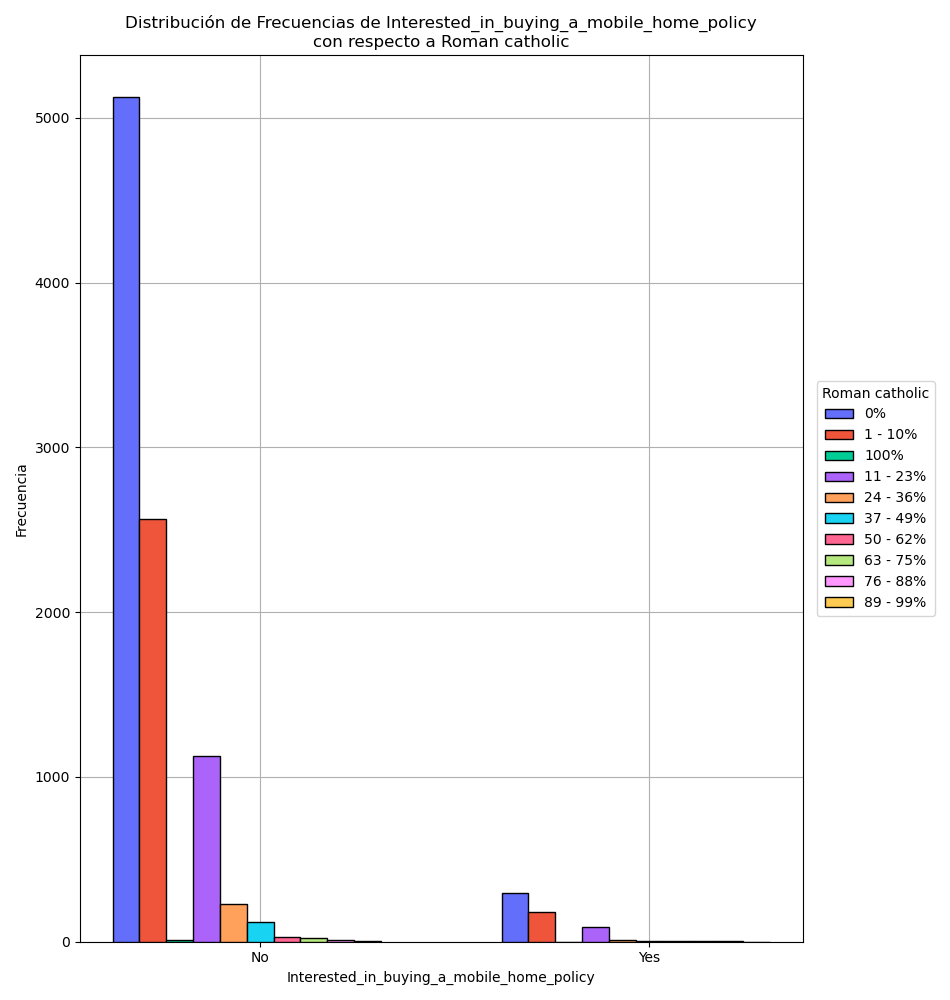

In [14]:
frequencyTableWithBothDetailLevels, pivotTablesList["Roman catholic"], cellsIndexesWithZeroValuesBySelectedColumns, cellsIndexesWithMaximumValueBySelectedColumns, cellsIndexesWithMinimumValueBySelectedColumns = buildCountingPivotTableFor2DetailLevels(labeledDatasetFile, nombreColumnaSalida, "Label_Roman_catholic", nombreColumnaDuplicadaSalida, nombreColumnaFase)
display(pivotTablesList["Roman catholic"].style.apply(highlightCountingPivotTableFor2DetailLevels, axis = None))

variablesIndependenceDecisionConfirmation, expectedFrequencyTableWithBothDetailLevels = applyHypothesisTestForVariablesIndependence(frequencyTableWithBothDetailLevels, "Roman catholic", nombreColumnaDuplicadaSalida, confidenceRatio = confidenceRatioForIndependeceHypothesisTest)
if variablesIndependenceDecisionConfirmation == True:
    outputIndependentVariableslist.append("Roman catholic")
else:
    outputDependentVariableslist.append("Roman catholic")

plt.figure(num = 6, figsize = (9.5, 10))
plotFrequencyTables(frequencyTableWithBothDetailLevels, nombreColumnaDuplicadaSalida, "Roman catholic", barWidth = 1.0, barOffset = 3.5, barPlotOriginalOrientation = False)
plt.show()

Se va a realizar una prueba de hipótesis de independencia de variables, para las variables Protestant y Interested_in_buying_a_mobile_home_policy con un valor de confianza de 0.99
Se tiene un total de 9822 observaciones, la variable Protestant toma 10 valores posibles, y la variable Interested_in_buying_a_mobile_home_policy toma 2 valores posibles
Se tiene(n) 9 grado(s) de libertad, un valor estadístico crítico de 21.665994333461924 y un valor estadístico de prueba de  26.532429192493254
Como el valor de prueba supera el valor crítico, por lo tanto se rechaza la hipótesis nula de independencia de las variables, es decir, se tiene dependencia entre las variables Protestant y Interested_in_buying_a_mobile_home_policy


<IPython.core.display.Javascript object>


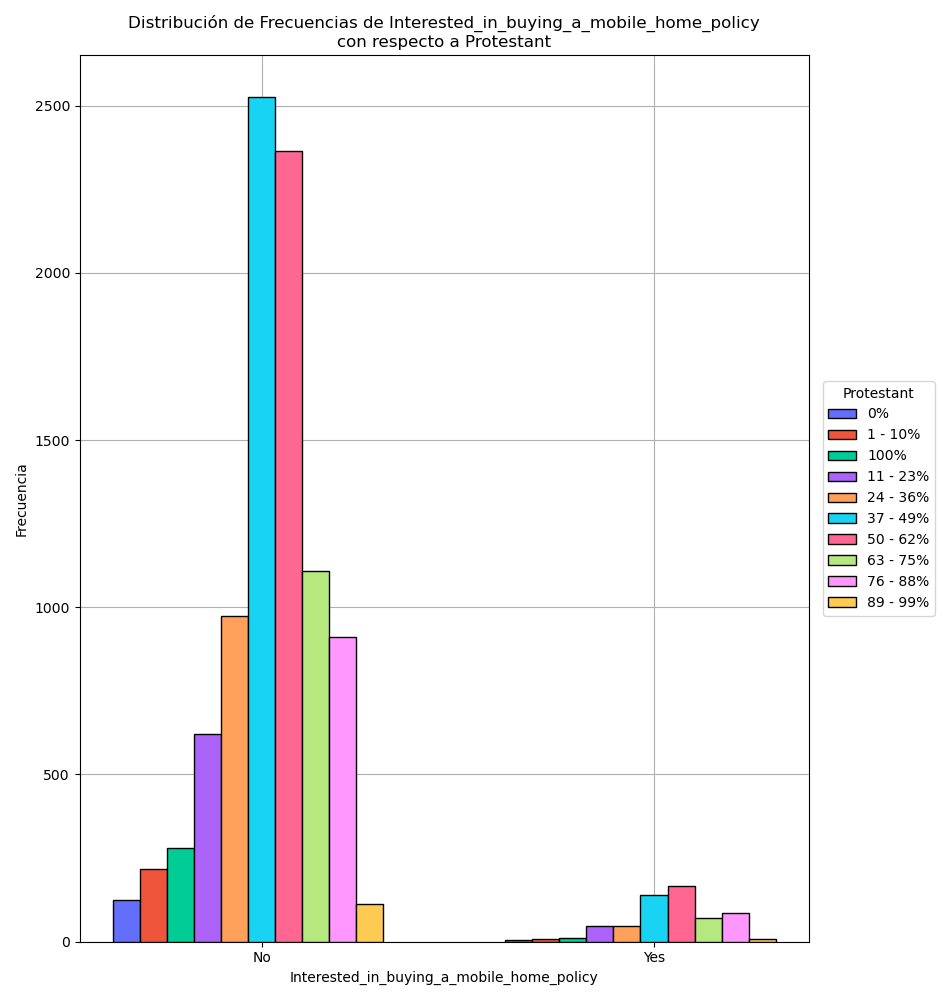

In [15]:
frequencyTableWithBothDetailLevels, pivotTablesList["Protestant"], cellsIndexesWithZeroValuesBySelectedColumns, cellsIndexesWithMaximumValueBySelectedColumns, cellsIndexesWithMinimumValueBySelectedColumns = buildCountingPivotTableFor2DetailLevels(labeledDatasetFile, nombreColumnaSalida, "Label_Protestant", nombreColumnaDuplicadaSalida, nombreColumnaFase)
display(pivotTablesList["Protestant"].style.apply(highlightCountingPivotTableFor2DetailLevels, axis = None))

variablesIndependenceDecisionConfirmation, expectedFrequencyTableWithBothDetailLevels = applyHypothesisTestForVariablesIndependence(frequencyTableWithBothDetailLevels, "Protestant", nombreColumnaDuplicadaSalida, confidenceRatio = confidenceRatioForIndependeceHypothesisTest)
if variablesIndependenceDecisionConfirmation == True:
    outputIndependentVariableslist.append("Protestant")
else:
    outputDependentVariableslist.append("Protestant")

plt.figure(num = 7, figsize = (9.5, 10))
plotFrequencyTables(frequencyTableWithBothDetailLevels, nombreColumnaDuplicadaSalida, "Protestant", barWidth = 1.0, barOffset = 3.5, barPlotOriginalOrientation = False)
plt.show()

Se va a realizar una prueba de hipótesis de independencia de variables, para las variables Other religion y Interested_in_buying_a_mobile_home_policy con un valor de confianza de 0.99
Se tiene un total de 9822 observaciones, la variable Other religion toma 6 valores posibles, y la variable Interested_in_buying_a_mobile_home_policy toma 2 valores posibles
Se tiene(n) 5 grado(s) de libertad, un valor estadístico crítico de 15.08627246938899 y un valor estadístico de prueba de  14.577810647637676
Como el valor de prueba no supera el valor crítico, por lo tanto se acepta la hipótesis nula de independencia de las variables, es decir, se tiene independencia entre las variables Other religion y Interested_in_buying_a_mobile_home_policy


<IPython.core.display.Javascript object>


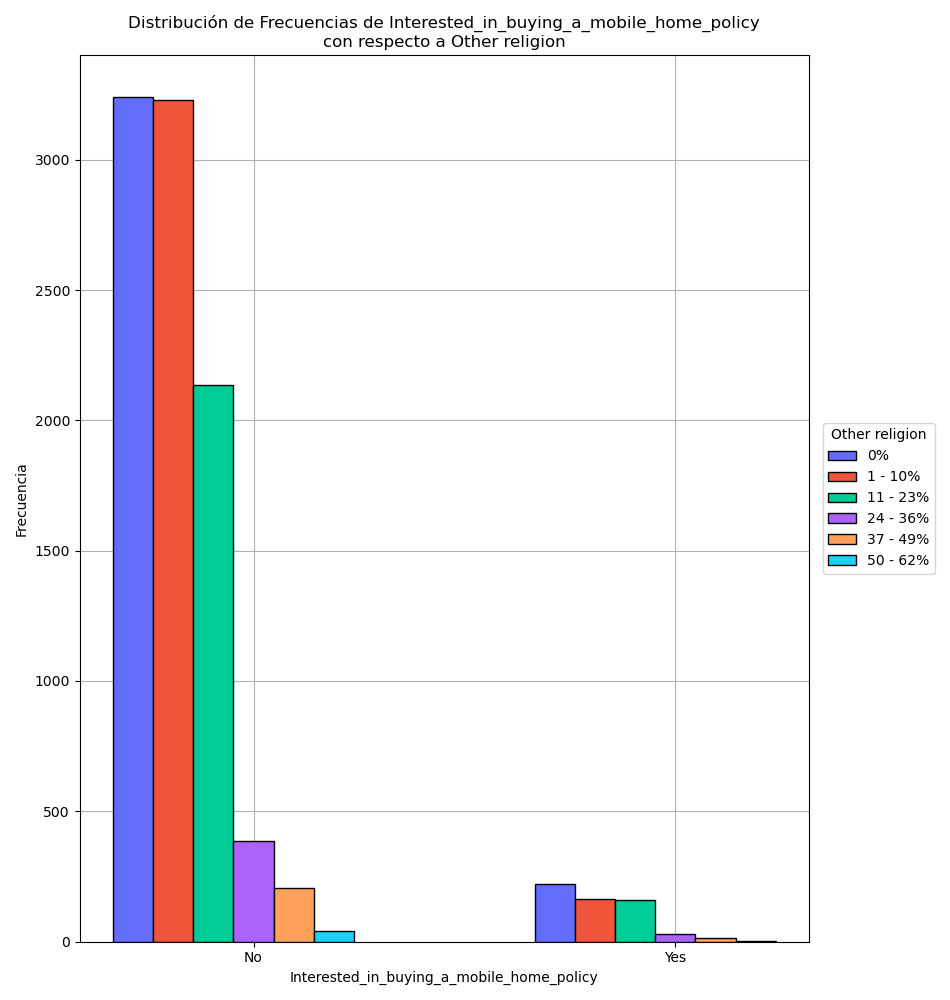

In [16]:
frequencyTableWithBothDetailLevels, pivotTablesList["Other religion"], cellsIndexesWithZeroValuesBySelectedColumns, cellsIndexesWithMaximumValueBySelectedColumns, cellsIndexesWithMinimumValueBySelectedColumns = buildCountingPivotTableFor2DetailLevels(labeledDatasetFile, nombreColumnaSalida, "Label_Other_religion", nombreColumnaDuplicadaSalida, nombreColumnaFase)
display(pivotTablesList["Other religion"].style.apply(highlightCountingPivotTableFor2DetailLevels, axis = None))

variablesIndependenceDecisionConfirmation, expectedFrequencyTableWithBothDetailLevels = applyHypothesisTestForVariablesIndependence(frequencyTableWithBothDetailLevels, "Other religion", nombreColumnaDuplicadaSalida, confidenceRatio = confidenceRatioForIndependeceHypothesisTest)
if variablesIndependenceDecisionConfirmation == True:
    outputIndependentVariableslist.append("Other religion")
else:
    outputDependentVariableslist.append("Other religion")

plt.figure(num = 8, figsize = (9.5, 10))
plotFrequencyTables(frequencyTableWithBothDetailLevels, nombreColumnaDuplicadaSalida, "Other religion", barWidth = 1.0, barOffset = 3.5, barPlotOriginalOrientation = False)
plt.show()

Se va a realizar una prueba de hipótesis de independencia de variables, para las variables No religion y Interested_in_buying_a_mobile_home_policy con un valor de confianza de 0.99
Se tiene un total de 9822 observaciones, la variable No religion toma 10 valores posibles, y la variable Interested_in_buying_a_mobile_home_policy toma 2 valores posibles
Se tiene(n) 9 grado(s) de libertad, un valor estadístico crítico de 21.665994333461924 y un valor estadístico de prueba de  19.104317648947017
Como el valor de prueba no supera el valor crítico, por lo tanto se acepta la hipótesis nula de independencia de las variables, es decir, se tiene independencia entre las variables No religion y Interested_in_buying_a_mobile_home_policy


<IPython.core.display.Javascript object>


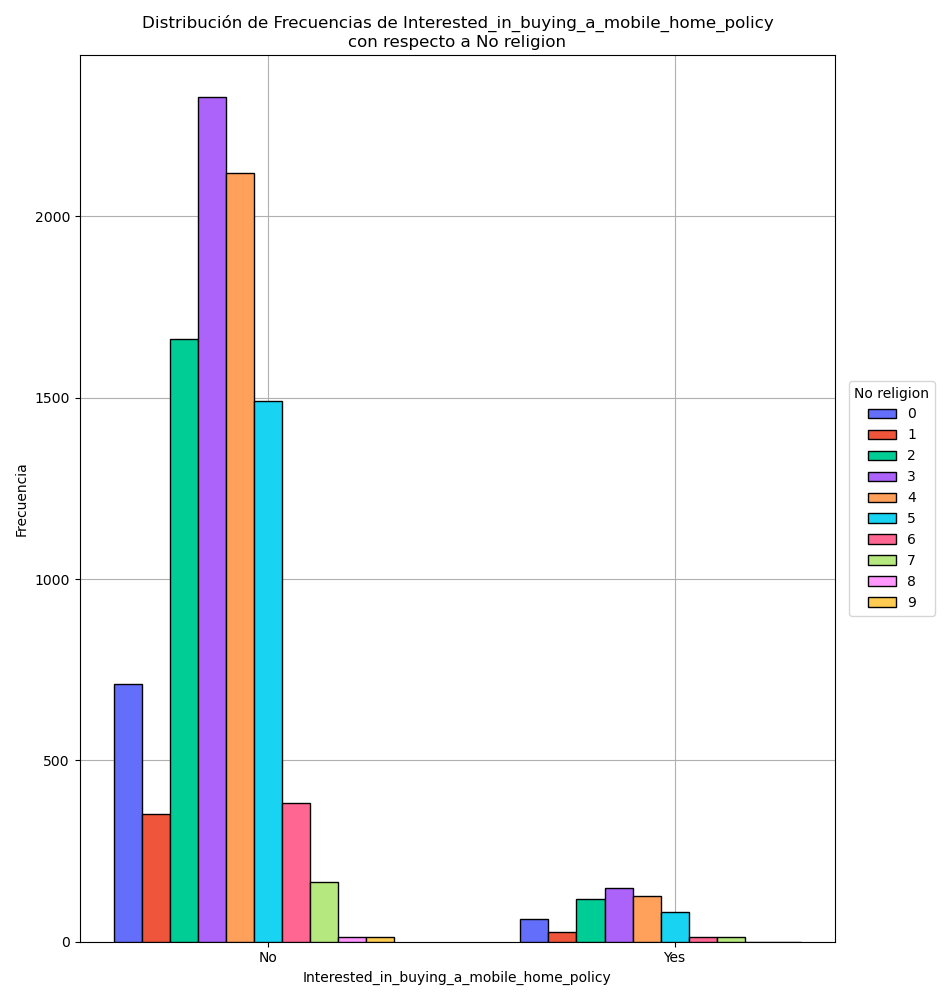

In [17]:
frequencyTableWithBothDetailLevels, pivotTablesList["No religion"], cellsIndexesWithZeroValuesBySelectedColumns, cellsIndexesWithMaximumValueBySelectedColumns, cellsIndexesWithMinimumValueBySelectedColumns = buildCountingPivotTableFor2DetailLevels(labeledDatasetFile, nombreColumnaSalida, "No_religion", nombreColumnaDuplicadaSalida, nombreColumnaFase)
display(pivotTablesList["No religion"].style.apply(highlightCountingPivotTableFor2DetailLevels, axis = None))

variablesIndependenceDecisionConfirmation, expectedFrequencyTableWithBothDetailLevels = applyHypothesisTestForVariablesIndependence(frequencyTableWithBothDetailLevels, "No religion", nombreColumnaDuplicadaSalida, confidenceRatio = confidenceRatioForIndependeceHypothesisTest)
if variablesIndependenceDecisionConfirmation == True:
    outputIndependentVariableslist.append("No religion")
else:
    outputDependentVariableslist.append("No religion")

plt.figure(num = 9, figsize = (9.5, 10))
plotFrequencyTables(frequencyTableWithBothDetailLevels, nombreColumnaDuplicadaSalida, "No religion", barWidth = 1.0, barOffset = 3.5, barPlotOriginalOrientation = False)
plt.show()

Se va a realizar una prueba de hipótesis de independencia de variables, para las variables Married y Interested_in_buying_a_mobile_home_policy con un valor de confianza de 0.99
Se tiene un total de 9822 observaciones, la variable Married toma 10 valores posibles, y la variable Interested_in_buying_a_mobile_home_policy toma 2 valores posibles
Se tiene(n) 9 grado(s) de libertad, un valor estadístico crítico de 21.665994333461924 y un valor estadístico de prueba de  49.04415817994978
Como el valor de prueba supera el valor crítico, por lo tanto se rechaza la hipótesis nula de independencia de las variables, es decir, se tiene dependencia entre las variables Married y Interested_in_buying_a_mobile_home_policy


<IPython.core.display.Javascript object>


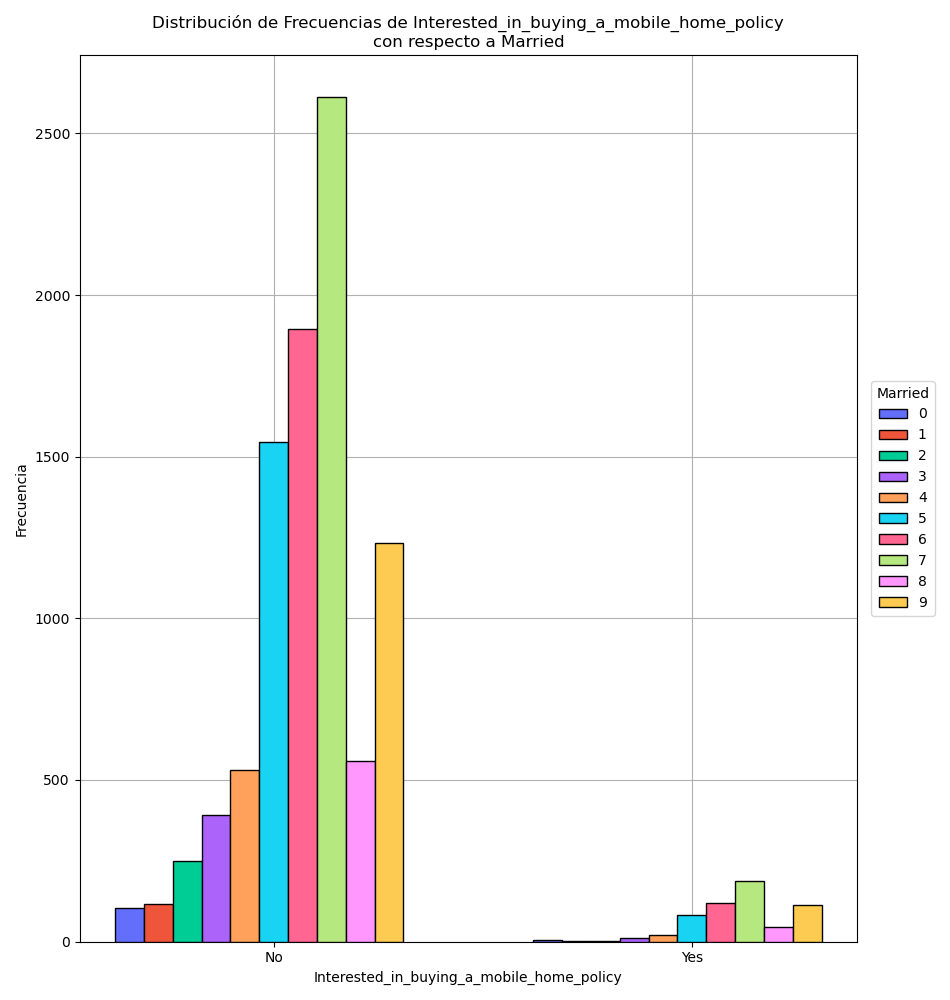

In [18]:
frequencyTableWithBothDetailLevels, pivotTablesList["Married"], cellsIndexesWithZeroValuesBySelectedColumns, cellsIndexesWithMaximumValueBySelectedColumns, cellsIndexesWithMinimumValueBySelectedColumns = buildCountingPivotTableFor2DetailLevels(labeledDatasetFile, nombreColumnaSalida, "Married", nombreColumnaDuplicadaSalida, nombreColumnaFase)
display(pivotTablesList["Married"].style.apply(highlightCountingPivotTableFor2DetailLevels, axis = None))

variablesIndependenceDecisionConfirmation, expectedFrequencyTableWithBothDetailLevels = applyHypothesisTestForVariablesIndependence(frequencyTableWithBothDetailLevels, "Married", nombreColumnaDuplicadaSalida, confidenceRatio = confidenceRatioForIndependeceHypothesisTest)
if variablesIndependenceDecisionConfirmation == True:
    outputIndependentVariableslist.append("Married")
else:
    outputDependentVariableslist.append("Married")

plt.figure(num = 10, figsize = (9.5, 10))
plotFrequencyTables(frequencyTableWithBothDetailLevels, nombreColumnaDuplicadaSalida, "Married", barWidth = 1.0, barOffset = 3.5, barPlotOriginalOrientation = False)
plt.show()